In [1]:

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
%matplotlib inline


In [2]:
import quandl as q 

In [3]:
q.ApiConfig.api_key = '11sy5SMsFERx_YypjsMi'

In [4]:
data = q.get('BITFINEX/BTCUSD') 

In [5]:
data

,High,Low,Mid,Last,Bid,Ask,Volume
Date,,,,,,,
2014-04-15,513.9000,452.00,504.23500,505.000000,503.5000,504.97,21013.584774
2014-04-16,547.0000,495.00,537.50000,538.000000,537.0000,538.00,29633.358705
2014-04-17,538.5000,486.10,507.02000,508.000000,506.0400,508.00,20709.783819
2014-04-18,509.0000,474.25,483.77000,482.750000,482.7500,484.79,10458.045243
2014-04-19,513.9899,473.83,505.01065,507.499900,502.5313,507.49,8963.618369
...,...,...,...,...,...,...,...
2021-10-27,61450.0000,57950.00,58518.00000,58517.000000,58517.0000,58519.00,7184.592265
2021-10-28,62444.0000,57606.00,60599.50000,60600.000000,60599.0000,60600.00,7949.438417
2021-10-29,62980.0000,60188.00,62292.50000,62295.000000,62292.0000,62293.00,4041.750450


In [6]:
DAYS_FUTURE=50
DAYS_PAST=50

HP_UNITS=100
HP_LAYERS=3

TRAIN_START="2015-01-01"
TRAIN_END="2019-01-01"

TEST_START="2019-01-01"
TEST_END="2020-01-01"

HP_DROPOUT = 0.5
HP_LR = 0.001
HP_BATCH_SIZE = 2048
HP_EPOCHS = 300

<AxesSubplot:xlabel='Date'>

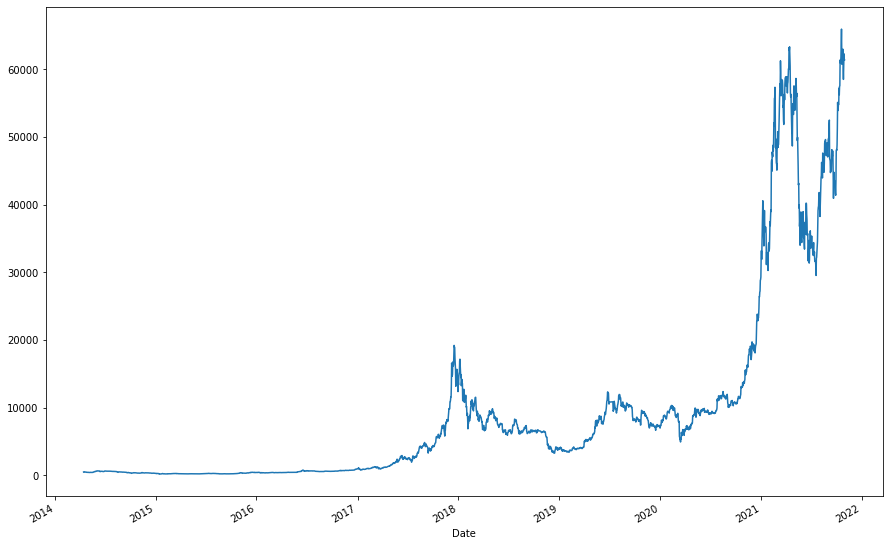

In [7]:
# show candles
data['Last'].plot(figsize=(15,10))

In [8]:
for i in range(1, DAYS_PAST):
    data['prev' + str(i)] = np.log(data['Last'] / data['Last'].shift(i))


In [9]:
for i in range(1, DAYS_FUTURE):
    data['next' + str(i)] = np.log(data['Last'] / data['Last'].shift(-i))


In [10]:
data

,High,Low,Mid,Last,Bid,Ask,Volume,prev1,prev2,prev3,...,next40,next41,next42,next43,next44,next45,next46,next47,next48,next49
Date,,,,,,,,,,,,,,,,,,,,,
2014-04-15,513.9000,452.00,504.23500,505.000000,503.5000,504.97,21013.584774,NaN,NaN,NaN,...,-0.133630,-0.126886,-0.125419,-0.213369,-0.213193,-0.246241,-0.275153,-0.244692,-0.271764,-0.256253
2014-04-16,547.0000,495.00,537.50000,538.000000,537.0000,538.00,29633.358705,0.063300,NaN,NaN,...,-0.063585,-0.062119,-0.150069,-0.149893,-0.182941,-0.211853,-0.181392,-0.208464,-0.192953,-0.199369
2014-04-17,538.5000,486.10,507.02000,508.000000,506.0400,508.00,20709.783819,-0.057377,0.005923,NaN,...,-0.119496,-0.207446,-0.207270,-0.240318,-0.269230,-0.238769,-0.265841,-0.250330,-0.256746,-0.258480
2014-04-18,509.0000,474.25,483.77000,482.750000,482.7500,484.79,10458.045243,-0.050983,-0.108360,-0.045060,...,-0.258429,-0.258253,-0.291301,-0.320213,-0.289751,-0.316823,-0.301312,-0.307728,-0.309463,-0.298227
2014-04-19,513.9899,473.83,505.01065,507.499900,502.5313,507.49,8963.618369,0.049998,-0.000985,-0.058362,...,-0.208255,-0.241303,-0.270215,-0.239754,-0.266826,-0.251315,-0.257731,-0.259465,-0.248229,-0.258401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-27,61450.0000,57950.00,58518.00000,58517.000000,58517.0000,58519.00,7184.592265,-0.027325,-0.073627,-0.040983,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-28,62444.0000,57606.00,60599.50000,60600.000000,60599.0000,60600.00,7949.438417,0.034978,0.007653,-0.038649,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-29,62980.0000,60188.00,62292.50000,62295.000000,62292.0000,62293.00,4041.750450,0.027586,0.062564,0.035239,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
import tensorflow as tf


In [12]:
# create an MLP model
def create_model(input_shape, output_shape):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=HP_UNITS, activation='relu', input_shape=input_shape))
    for _ in range(HP_LAYERS):
        model.add(tf.keras.layers.Dense(units=HP_UNITS, activation='relu'))
    model.add(tf.keras.layers.Dense(units=output_shape, activation='linear'))
    model.compile(loss='mse', optimizer='adam')
    return model

    